<a href="https://colab.research.google.com/github/Mai1902/landing/blob/main/CMPSC600_Demo_Lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install sklearn
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=a235f8742ac8237a1e8cf7fa2ad45a3c1a6f63cad87eb1173211d8799e4fb0c9
  Stored in directory: /root/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from sklearn import feature_extraction
from nltk.stem import PorterStemmer
import PyPDF2

In [ ]:
# Load job description file
df = pd.read_csv('dice_com_techjob_post.csv')
im_df = pd.DataFrame(df, columns = ['company', 'employment', 'jobdescription', 'jobtitle', 'skills'])
data_dict = im_df.to_dict()
jd_content = [x for x in data_dict['jobdescription'].values()]
skills = [x for x in data_dict['skills'].values()]
skills_cleaned = []

for skill in skills:
    skill = str(skill)
    skill = skill.split(',')
    for entity in skill:
      if 'see' not in entity and 'See' not in entity and 'SEE' not in entity:
        skills_cleaned.append(entity)

print(skills_cleaned[:20])
jd_content_sample = jd_content[:10000]

im_df.head(20)


In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download('punkt')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# prepare a data frame of only skills and job title to train
col = ['jobtitle', 'skills']
data_eval = im_df[col]

# If skills contain see, check jobdescription:

# Drop rows with missing data
data_eval.dropna(subset=['skills'], inplace=True)


data_forfit = data_eval['skills']
data_eval.head()


In [ ]:
# define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, min_df = 0.001, use_idf=True, stop_words= 'english')

tfidf_matrix = tfidf_vectorizer.fit_transform(data_forfit)
print(tfidf_matrix.shape)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# generate k-cluster

num_clusters = 70

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.predict(tfidf_matrix)

In [ ]:
#add cluster name into the df
data_eval["ClusterName"] = clusters
data_eval.head(20)



In [ ]:
fileOb = open('Resume.pdf','rb')
pdfReader = PyPDF2.PdfFileReader(fileOb)
page = pdfReader.getPage(0)
content = page.extractText()

cluster = km.predict(tfidf_vectorizer.transform([content])) 

print(cluster)

[14]


In [ ]:
ind = []
for i in data_eval.index:
  if int(data_eval["ClusterName"][i]) == int(cluster):
    ind.append(i)
match_df = im_df.loc[ind]
match_df.shape


In [ ]:
from collections import Counter

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


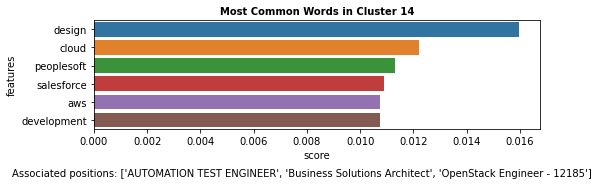

In [ ]:
def cluster_name(prediction, data_eval):
  labels = []
  for cluster in prediction:
    title_list = []
    for i in data_eval.index:
      if int(data_eval['ClusterName'][i]) == cluster:
        for word in data_eval['jobtitle'][i].split(' '):
          title_list.append(word)
    occurence_count = Counter(title_list)
    label = occurence_count.most_common(1)[0][0]
    labels.append(label)
  return labels

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def get_job(data_eval):

  dict_job = {}

  for ind in data_eval.index:
    i = data_eval['ClusterName'][ind]
    if i not in dict_job.keys():
      dict_job[i] = []
      dict_job[i].append(data_eval['jobtitle'][ind])
    else:
      dict_job[i].append(data_eval['jobtitle'][ind])
  
  return dict_job

def plotWords(dfs, n_feats, data_eval):
    job = get_job(data_eval)
    for i in range(14, 15):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.figtext(0.99, - 0.2, f'Associated positions: {job[i][:3]}', horizontalalignment='right')
        

#labels = cluster_name(clusters, data_eval)
#print(labels, " ")
dfs = get_top_features_cluster(tfidf_matrix.toarray(), clusters, 6)
plotWords(dfs, 6, data_eval)



In [ ]:
match_df = match_df[:100]
match_df.shape

(100, 5)

In [ ]:
import en_core_web_sm

In [ ]:
from spacy.matcher import PhraseMatcher, Matcher

In [ ]:
master = en_core_web_sm.load()

In [ ]:
# Match job to a list of position
def keyword_matching(text_resume, text_jd):
    # Generate matcher pattern by extracting keywords from job description
    rake = Rake()
    matcher = PhraseMatcher(master.vocab)
    rake.extract_keywords_from_text(text_jd)
    jd_keyword = rake.get_ranked_phrases()
    jd_keyword_count = Counter(jd_keyword)
    patterns = [master.make_doc(k) for k in jd_keyword]
    matcher.add("Spec", patterns) 

    # Matching the keyword in job description with resume
    text_resume = master(text_resume)
    matches = matcher(text_resume)
    match_keywords = [text_resume[start:end] for _, start, end in matches]

    # Count the amount of word matched and matching frequency
    matcher_report = Counter(match_keywords)

    # Calculate the keyword matching percentage between job description and resume
    matched_amount = len(matcher_report.keys())
    jd_keyword_amount = len(jd_keyword_count.keys())
    matcher_percentage = (matched_amount/jd_keyword_amount)*100

    return match_keywords, matcher_percentage



In [ ]:
!pip install rake_nltk

In [ ]:
from rake_nltk import Rake

In [ ]:
from nltk.tokenize import sent_tokenize

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def tokenizer(text):
  tokens = []
  for sent in sent_tokenize(text):
    for token in word_tokenize(sent):
      tokens.append(token)
  return tokens

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
# Calculate match and return top 5

scores = []
matches_kws = []

for ind in match_df.index:
  text_jd = match_df['jobdescription'][ind]
  score = keyword_matching(content, text_jd)[1]
  scores.append(score)
  matches_kw = keyword_matching(content, text_jd)[0]
  matches_kws.append(matches_kw)

match_df['MatchingPercentage'] = pd.Series(scores)
match_df['KeywordMatched'] = pd.Series(matches_kws)





In [ ]:
match_df.head(5)

In [ ]:
# Return top 5:
temp_df = match_df.copy()
top_df = match_df.copy()
amount = 5
max_ind = []
while(amount > 0):
  max = 0
  max_id = 0
  for ind in temp_df.index:
    if temp_df['MatchingPercentage'][ind] > max:
      max_id = ind
      max = temp_df['MatchingPercentage'][ind]

  max_ind.append(max_id)
  temp_df['MatchingPercentage'][max_id] = 0
  amount -= 1

top_df.loc[max_ind]

In [ ]:
# Return missing keyphrase from a job
text = top_df['jobdescription'][17]
rake = Rake()
rake.extract_keywords_from_text(text)
key_jd = rake.get_ranked_phrases()[:10]
kw_m = [str(w) for w in top_df['KeywordMatched'][17]]
missing = []
for kw in key_jd:
  if kw not in kw_m:
    missing.append(kw)
kw_m = ','.join(kw_m)
print(f'Matched key phrase: {kw_m}')
print()
i = 1
for ms in missing:
  print(f'Top {i} missing phrase: {ms}')
  print()
  i+= 1


In [ ]:
def lemmatization(text):
    text = master(text)
    token_list = []
    for token in text:
        token_list.append(token.lemma_)

    lemmatized_text = ' '.join(token_list)
    return lemmatized_text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def similarity_caculator(text_resume, text_jd):
    text_resume = lemmatization(text_resume)
    text_jd = lemmatization(text_jd)
    text_list = [text_resume, text_jd]
    cv = CountVectorizer()
    count_vector = cv.fit_transform(text_list)
    matchPercentage = cosine_similarity(count_vector)[0][1]*100
    matchPercentage = round(matchPercentage,2)
    return matchPercentage


In [ ]:
#Calculate Similarity using cosine similarity
similarityscore = []
for ind in match_df.index:
  score = similarity_caculator(content, match_df['jobdescription'][ind])
  similarityscore.append(score)
match_df['SimilarityScore'] = pd.Series(similarityscore)
match_df.head()

In [ ]:
temp_df1 = match_df.copy()
amount = 5
max_ind = []
while(amount > 0):
  max = 0
  max_id = 0
  for ind in temp_df1.index:
    if temp_df1['SimilarityScore'][ind] > max:
      max_id = ind
      max = temp_df1['SimilarityScore'][ind]

  max_ind.append(max_id)
  temp_df1['SimilarityScore'][max_id] = 0
  amount -= 1

top_df1 = match_df.loc[max_ind]
top_df1.head()

In [ ]:
# Print out list of job
i = 0
for ind in top_df1.index:
  company = top_df1['company'][ind]
  title = top_df1['jobtitle'][ind]
  matching_percentage = top_df1['MatchingPercentage'][ind]
  similarity_score = top_df1['SimilarityScore'][ind]
  link = df['advertiserurl'][ind]
  print('-----------------------------------------')
  print(f'Rank {i} match based on similarity score:\n')
  print(f'Company:\t{company}\n')
  print(f'Title:\t{title}\n')
  print(f'Matching Percentage by phrase matching:\t{matching_percentage}\n')
  print(f'Similarity Score\t{similarity_score}\n')
  print(f'Link: {link}')
  i += 1
  print('------------------------------------------')


In [ ]:
!pip install gensim

In [ ]:
# Switch to LDA approach
from gensim import corpora, models, similarities


In [ ]:
!pip install rake_nltk

In [ ]:
# Get keyword only from jd_content using Rake
rake = Rake()
def get_kw_rake(jd_content):
  for jd in jd_content:
    rake.extract_keywords_from_text(jd)
  keywords = rake.get_ranked_phrases()
  return keywords
